In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import glob
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import time
import seaborn as sn
import time

import jax.numpy as jnp
from jax import jit, grad, vmap
from functools import partial
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy, A2CPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb
from tianshou.trainer.utils import gather_info, test_episode

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import *
from lib.policy import MarlPPOPolicy, IndpPGPolicy
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer
from lib.models import FcNN, MyFCNNActorProb, MyFCNNCriticProb
from lib.models import *

#temporary solution for xlb imports
sys.path.append(os.path.abspath(os.path.expanduser('~/XLB')))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs


#from lib.custom_tianshou.my_actors import MyActorProb

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(42)
torch.manual_seed(42)

In [3]:
class test_network(nn.Module):

    def __init__(self, device="cpu", in_channels=9, feature_dim=27, out_channels=1, padding_mode="circular"):
        super().__init__()
        self.device = device
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=feature_dim, kernel_size=1, stride=1,
                       padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=feature_dim, out_channels=feature_dim, kernel_size=1, stride=1,
                       padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=feature_dim, out_channels=out_channels, kernel_size=1, stride=1,
                       padding=0, bias=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, obs, state=None, info={}):
        if not isinstance(obs, torch.Tensor):
            obs = torch.tensor(obs, dtype=torch.float, device=self.device)
        batch = obs.shape[0]

        values = self.model(obs.reshape(batch, -1, 128, 128))
        values = values.reshape(batch,128,128)
        return values
    

class fcnn(nn.Module):
    def __init__(self):
        super(fcnn, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(9, 27),
            nn.ReLU(),
            nn.Linear(27, 27),
            nn.ReLU(),
            nn.Linear(27,1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [4]:
model = test_network()
model2 = fcnn()

In [5]:
print(model.model[0].weight.shape)
print(model.model[0].bias.shape)
print(model.model[2].weight.shape)
print(model.model[2].bias.shape)
print(model.model[4].weight.shape)
print(model.model[4].bias.shape)

print("**********************")

print(model2.model[0].weight.shape)
print(model2.model[0].bias.shape)
print(model2.model[2].weight.shape)
print(model2.model[2].bias.shape)
print(model2.model[4].weight.shape)
print(model2.model[4].bias.shape)

torch.Size([27, 9, 1, 1])
torch.Size([27])
torch.Size([27, 27, 1, 1])
torch.Size([27])
torch.Size([1, 27, 1, 1])
torch.Size([1])
**********************
torch.Size([27, 9])
torch.Size([27])
torch.Size([27, 27])
torch.Size([27])
torch.Size([1, 27])
torch.Size([1])


In [4]:
#######################################################################################################
####### environments ##################################################################################
#######################################################################################################
seeds = np.array([102, 348, 270, 106, 71, 188, 20, 121, 214, 330, 87, 372,
              99, 359, 151, 130, 149, 308, 257, 343, 413, 293, 385, 191, 276,
              160, 313, 21, 252, 235, 344, 42])

assert seeds.shape[0] == np.unique(seeds).shape[0]
train_seeds = seeds[:29]
val_seeds = seeds[29:]
#test_seeds = np.array([69, 33, 420])
    
train_env = KolmogorovEnvironment11(seeds=train_seeds, max_episode_steps=1587, step_factor=1)
test_env = KolmogorovEnvironment12(seeds=train_seeds, max_episode_steps=1587, step_factor=1)
#######################################################################################################
####### Policy ########################################################################################
#######################################################################################################
assert train_env.observation_space.shape is not None  # for mypy
assert train_env.action_space.shape is not None
#initialize PPO
actor = MyFCNNActorProb2(in_channels=2, device=device).to(device)
critic = MyFCNNCriticProb2(in_channels=2, device=device).to(device)
actor_critic = ActorCritic(actor=actor, critic=critic)
optim = torch.optim.Adam(actor_critic.parameters(), lr=3e-4, eps=1e-7)
dist = torch.distributions.Normal
#dist = ElementwiseNormal

policy = MarlPPOPolicy(actor=actor,
    critic=critic, 
    optim=optim,
    dist_fn=dist, 
    action_space=train_env.action_space,
    discount_factor=0.9,
    reward_normalization=False, 
    advantage_normalization = False,
    value_clip = False,
    deterministic_eval=True,
    action_scaling= True,
    action_bound_method= "tanh",
    ent_coef = 1e-3,
    vf_coef = 5e-2,
    max_grad_norm = 1.,
    gae_lambda=0.9, 
    recompute_advantage=False,
)

#policy2 = PGPolicy(model=actor, optim=optim, dist_fn=dist, action_space=train_env.action_space,
#        discount_factor=0.9,reward_normalization=False, deterministic_eval=True,
#        observation_space=train_env.observation_space, action_scaling=True, action_bound_method = "tanh",
#    )
#
#policy3 = IndpPGPolicy(model=actor, optim=optim, dist_fn=dist, action_space=train_env.action_space,
#        discount_factor=0.9,reward_normalization=False, deterministic_eval=True,
#        observation_space=train_env.observation_space, action_scaling=True, action_bound_method = "tanh",
#    )


#######################################################################################################
####### Collectors ####################################################################################
#######################################################################################################
#train_collector = Collector(policy=policy, env=train_env, buffer=VectorReplayBuffer(args.buffer_size, len(train_env)))
train_collector = Collector(policy=policy, env=train_env, buffer=VectorReplayBuffer(20000, 1))
test_collector = Collector(policy=policy, env=test_env)
train_collector.reset()
test_collector.reset()

#######################################################################################################
####### Trainer #######################################################################################
#######################################################################################################
trainer = OnpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=2,
    step_per_epoch=100,
    repeat_per_collect=1,
    episode_per_test=1,
    batch_size=16,
    step_per_collect=32,
    #episode_per_collect=args.episode_per_collect,
    show_progress=True,
    #stop_fn=lambda mean_reward: mean_reward >= args.reward_threshold,
)

Re=10000, m_prime=1588, T=18.001958690024615, omega=1.9996472117476842
Re=10000, m_prime=25408, T=18.001958690024615, omega=1.99437028369627
Re=10000, m_prime=1588, T=18.001958690024615, omega=1.9996472117476842
Re=10000, m_prime=25408, T=18.001958690024615, omega=1.99437028369627


/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/site-packages/tianshou/data/collector.py:69: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")
/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/site-packages/tianshou/data/collector.py:69: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


Re=10000, m_prime=20025, T=227.00832667993888, omega=1.9996472117476842
Re=10000, m_prime=320400, T=227.00832667993888, omega=1.99437028369627
0 0.0
rew =  0.000


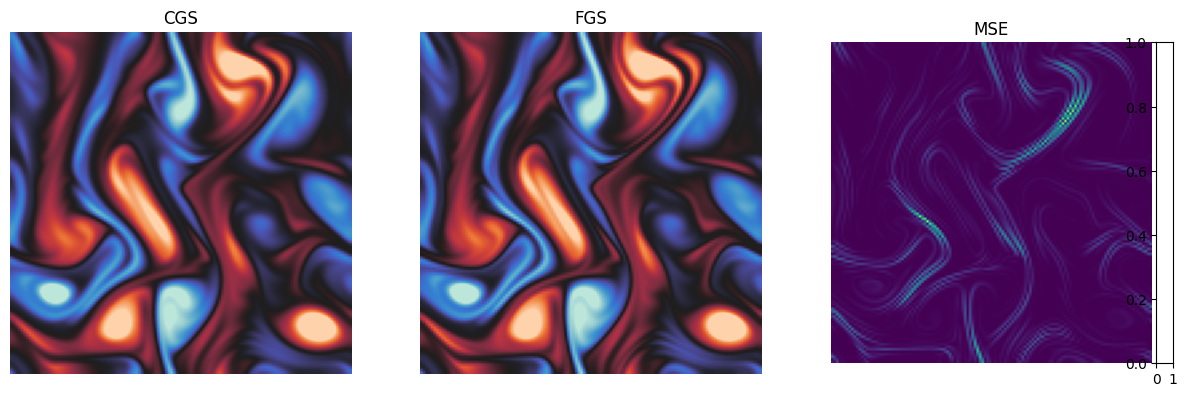

1000 0.9439334255561886
rew =  0.984


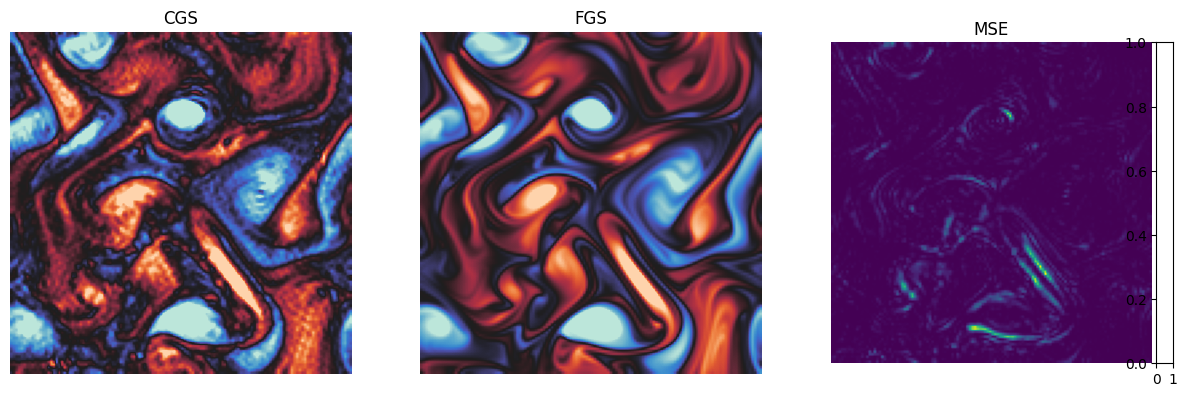

terminated
#steps = 1980, Total Reward = 1685.11200, Total discounted Reward = 33.327039150536365
Execution time: 6.959443092346191 seconds


: 

In [4]:
import time
#time one klmgrv5 episode
#env = KolmogorovEnvironment11(seeds=train_seeds, max_episode_steps=1587, step_factor=1)
#env = TransformObservation(env, lambda obs: (obs/0.00014))
env = KolmogorovEnvironment18(seeds=[102], step_factor=4)
start_time = time.time()
reward = np.zeros(env.action_space.shape)
discounted_reward = 0
f_min, f_max, f_mean=0.,0.,0.
gamma = 0.97
step = 0
act = np.zeros(env.action_space.shape)
#act[32:96, 32:96] = 0.996
obs ,inf = env.reset()
rew = np.zeros(env.action_space.shape)
episode_is_over = False
rews = []
obss = []
while not episode_is_over:
    if step%1000==0:
        print(step, rew.mean())
        print("rew = ", f"{rew[100,100]:.3f}")
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        env.render()

        #plot enerty spectra
        #E1, E2 = env.get_spectra()
        #plt.style.use('ggplot')
        #plt.figure(figsize=(8, 5), dpi=100)
        #plt.loglog(E1, label='cgs')
        #plt.loglog(E2, linestyle='dashed', label='fgs')
        #plt.ylabel(r'Energy spectrum $E(k)$')
        #plt.xlabel(r'wavenumber $k$')
        #plt.legend()
        #plt.show()

    obs, rew, terminated, truncated, inf = env.step(act)
    rews.append(rew)
    obss.append(obs)
    reward += rew
    discounted_reward += rew * gamma**step 
    f_min = np.min([f_min, obs.min()])
    f_max = np.max([f_min, obs.max()])
    f_mean += obs.mean()
    step += 1
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

f_mean /= step

print(f"#steps = {step}, Total Reward = {reward.mean():.5f}, Total discounted Reward = {discounted_reward.mean()}")
env.close()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [12]:
print(f_min, f_mean, f_max)

-15.742213964886226 4.407997220888668e-14 12.543732183469588


In [13]:
rews = np.array(rews)
obss = np.array(obss)

In [14]:
print(rews.min(), rews.mean(), rews.max(), rews.std())

1.0 1.0210039907582442 34.33333333333331 0.8364758559857113


### Analysis

In [3]:
#time one klmgrv5 episode
env = KolmogorovEnvironment16(seeds=[102], max_episode_steps=20000, step_factor=1)

Re=10000, m_prime=20025, T=227.00832667993888, omega=1.9996472117476842
Re=10000, m_prime=320400, T=227.00832667993888, omega=1.99437028369627


In [6]:

def plot_analysis(env, i, save_fig=False):
    # Calculate velocity magnitudes for CGS and FGS
    magnitude = lambda u : np.sqrt(np.sum(u**2, axis=-1))

    # Your plotting function
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots

    # Plot CGS, FGS, and MSE fields in the first row
    im1 = axes[0, 0].imshow(env.v1, vmin=-10, vmax=10, cmap=sn.cm.icefire)
    im2 = axes[0, 1].imshow(env.v2, vmin=-10, vmax=10, cmap=sn.cm.icefire)

    #plot enerty spectra
    E1, E2 = env.get_spectra()
    axes[0,2].loglog(E1, label="CGS")
    axes[0,2].loglog(E2, label="FGS")
    axes[0,2].legend()
    axes[0,2].set_title("Energy spectra")
    axes[0,2].set_xlabel("wavenumber k")
    axes[0,2].set_ylabel("Energy E(k)")   

    # Plot velocity magnitude for CGS and FGS in the second row
    im4 = axes[1, 0].imshow(magnitude(env.u1), cmap='plasma')
    im5 = axes[1, 1].imshow(magnitude(env.u2), cmap='plasma')

    #plot velocity MSE
    im6 = axes[1, 2].imshow(np.sum((env.u1 - env.u2)**2, axis=-1), cmap='viridis')

    # Hide axes for the third column of the second row (unused)
    axes[1, 2].axis('off')

    # Remove axis ticks for all subplots
    for ax in axes.flat:
        ax.axis('off')
    
    axes[0,2].axis('on')

    # Set titles for the subplots
    axes[0, 0].set_title("Vorticity CGS")
    axes[0, 1].set_title("Vorticity FGS")
    axes[0, 2].set_title("Energy Spectrum")
    axes[1, 0].set_title("Velocity Magnitude CGS")
    axes[1, 1].set_title("Velocity Magnitude FGS")
    axes[1, 2].set_title("Velocity MSE")

    # Create a colorbar for the third plot (MSE)
    divider = make_axes_locatable(axes[1, 2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im6, cax=cax)

    # Create colorbars for velocity magnitude plots
    divider_cgs = make_axes_locatable(axes[1, 0])
    cax_cgs = divider_cgs.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im4, cax=cax_cgs)

    divider_fgs = make_axes_locatable(axes[1, 1])
    cax_fgs = divider_fgs.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im5, cax=cax_fgs)

    # Show the plot
    plt.tight_layout()

    if save_fig == True:
        plt.savefig(f"visuals/img{i}.png", dpi=100)
        plt.close()
    else:
        plt.show()


In [7]:
#folder_path = "visuals/"
#image_files = glob.glob(os.path.join(folder_path, "*.png"))
#for image_file in image_files:
#    os.remove(image_file)

def plot_analysis2(env, i, save_fig=False):
    # Calculate velocity magnitudes for CGS and FGS
    magnitude = lambda u: np.sqrt(np.sum(u**2, axis=-1))

    # Create a 4x3 grid of subplots (4 rows now)
    fig, axes = plt.subplots(5, 3, figsize=(15, 25))

    # Plot CGS, FGS, and MSE fields in the first row
    im1 = axes[0, 0].imshow(env.v1, vmin=-10, vmax=10, cmap=sn.cm.icefire)
    im2 = axes[0, 1].imshow(env.v2, vmin=-10, vmax=10, cmap=sn.cm.icefire)

    # Plot energy spectra
    E1, E2 = env.get_spectra()
    axes[0, 2].loglog(E1, label="CGS")
    axes[0, 2].loglog(E2, label="FGS")
    axes[0, 2].legend()
    axes[0, 2].set_title("Energy spectra")
    axes[0, 2].set_xlabel("Wavenumber k")
    axes[0, 2].set_ylabel("Energy E(k)")

    # Plot velocity magnitude for CGS and FGS in the second row
    im4 = axes[1, 0].imshow(magnitude(env.u1), cmap='plasma')
    im5 = axes[1, 1].imshow(magnitude(env.u2), cmap='plasma')

    # Plot velocity MSE
    im6 = axes[1, 2].imshow(np.sum((env.u1 - env.u2)**2, axis=-1), cmap='viridis')

    # Remove axis ticks for all subplots except energy spectrum plot
    for ax in axes.flat:
        ax.axis('off')
    
    # Turn on axes only for energy spectrum plot
    axes[0, 2].axis('on')

    # Set titles for the subplots
    axes[0, 0].set_title("Vorticity CGS")
    axes[0, 1].set_title("Vorticity FGS")
    axes[0, 2].set_title("Energy Spectrum")
    axes[1, 0].set_title("Velocity Magnitude CGS")
    axes[1, 1].set_title("Velocity Magnitude FGS")
    axes[1, 2].set_title("Velocity MSE")

    # Create a colorbar for the velocity MSE plot
    divider = make_axes_locatable(axes[1, 2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im6, cax=cax)

    # Create colorbars for velocity magnitude plots
    divider_cgs = make_axes_locatable(axes[1, 0])
    cax_cgs = divider_cgs.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im4, cax=cax_cgs)

    divider_fgs = make_axes_locatable(axes[1, 1])
    cax_fgs = divider_fgs.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im5, cax=cax_fgs)

    # Plot the 9 images from env.f1 in the third and fourth rows, and add colorbars
    permutation = np.array([4,1,7,6,0,3,8,2,5])
    for idx in range(9):
        f = env.f1[:, :, permutation[idx]]
        f_max = f.max()
        row, col = divmod(idx, 3)
        im_f = axes[2 + row, col].imshow(f, cmap='seismic', vmin=-f_max, vmax=f_max)  # Change the colormap here to 'inferno'

        # Set title for each f1 image
        axes[2 + row, col].set_title(f"$f_{permutation[idx]}$")

        # Create colorbars for each f1 plot
        divider_f = make_axes_locatable(axes[2 + row, col])
        cax_f = divider_f.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im_f, cax=cax_f)

    # Remove axis ticks for all the f1 images
    for row in range(2, 4):
        for col in range(3):
            axes[row, col].axis('off')

    # Adjust layout and either show or save the figure
    plt.tight_layout()

    if save_fig:
        plt.savefig(f"visuals/img{i}.png", dpi=100)
        plt.close()
    else:
        plt.show()


In [57]:
env.cgs.lattice.c

Array([[ 0,  0,  0,  1, -1,  1, -1,  1, -1],
       [ 0,  1, -1,  0,  1, -1,  0,  1, -1]], dtype=int8)

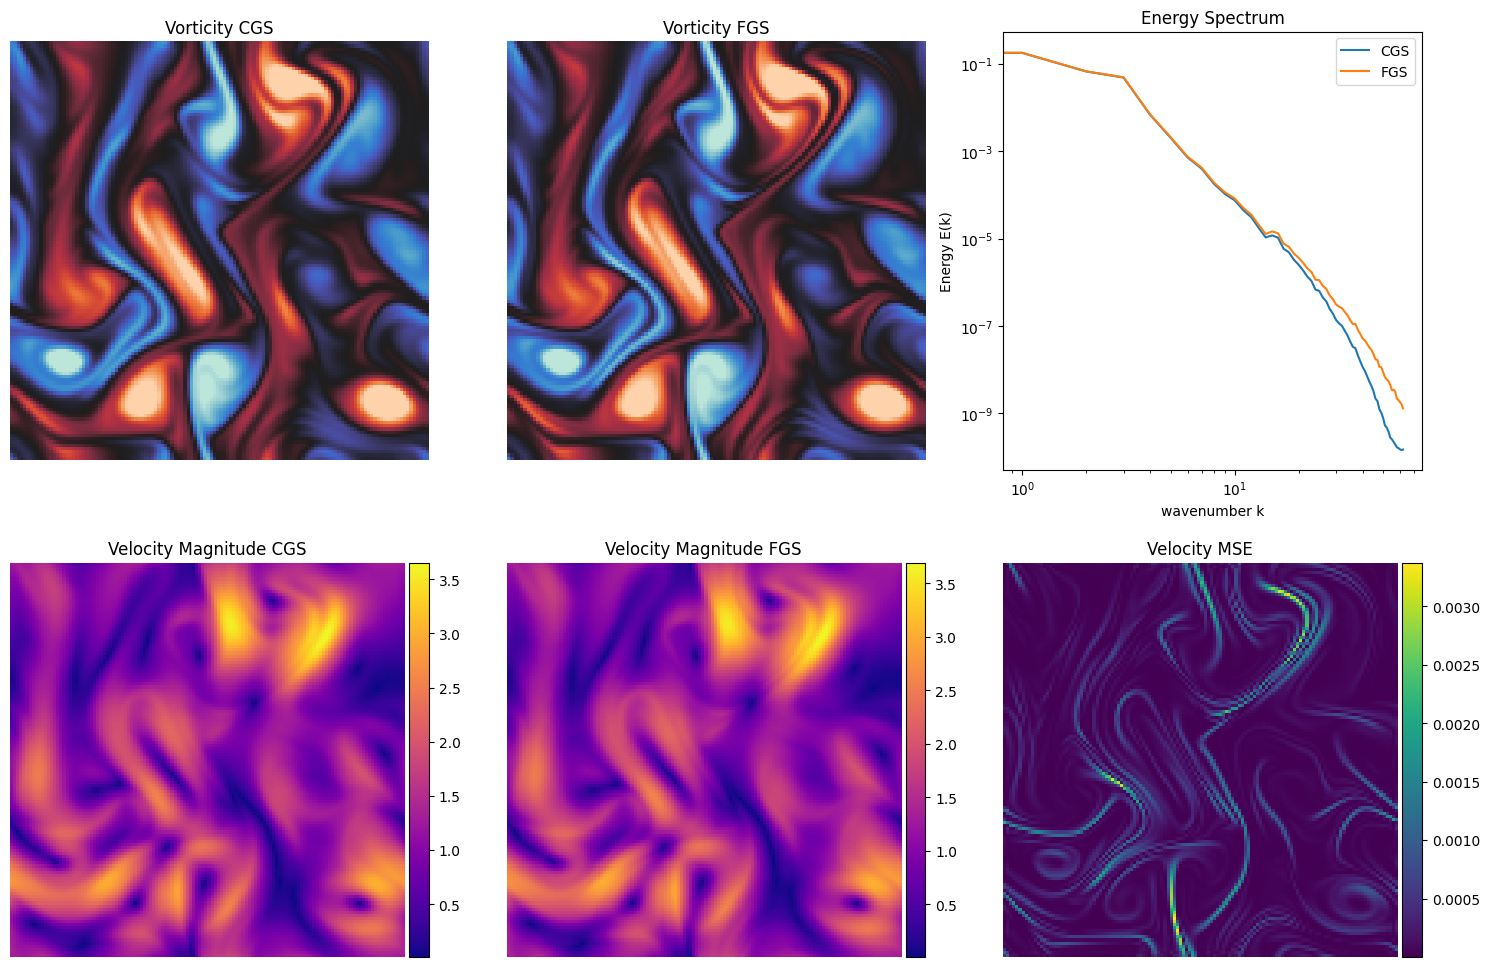

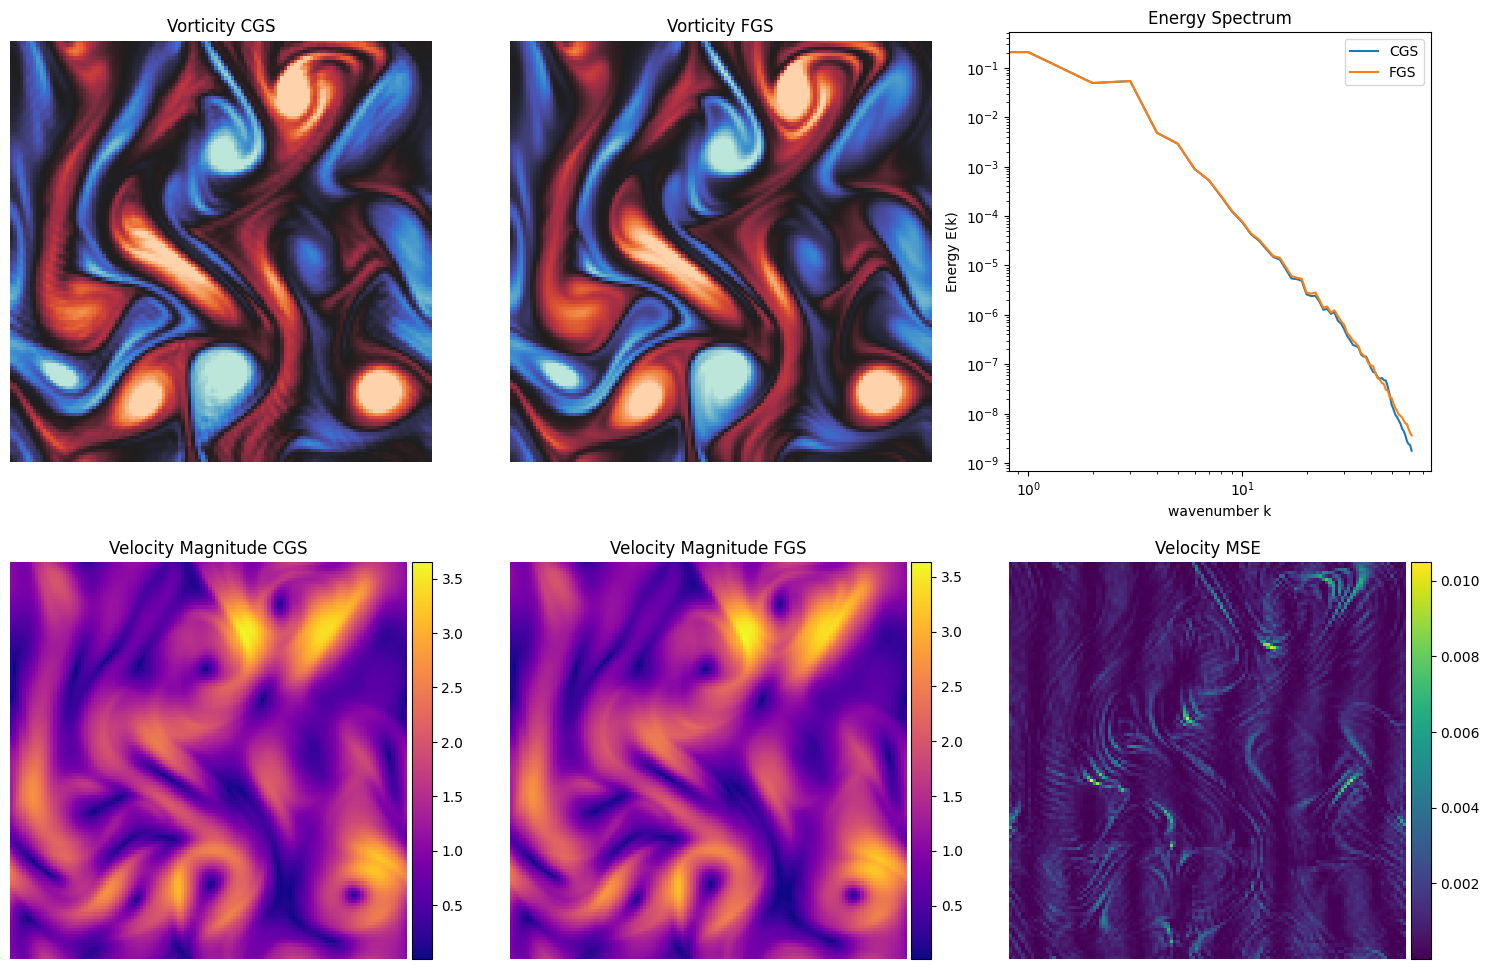

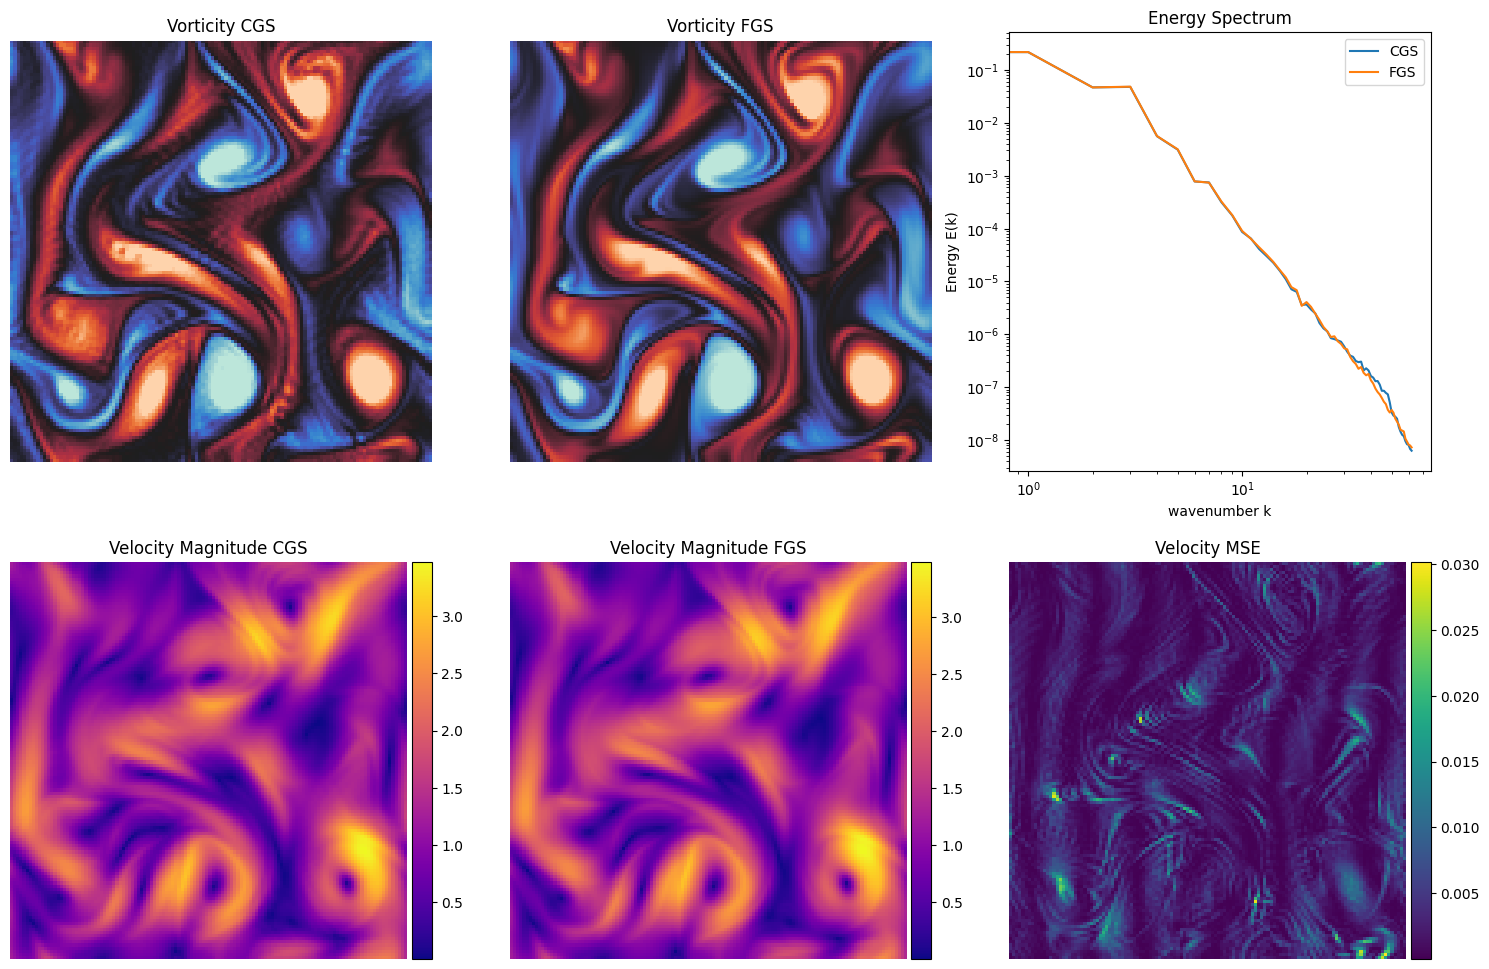

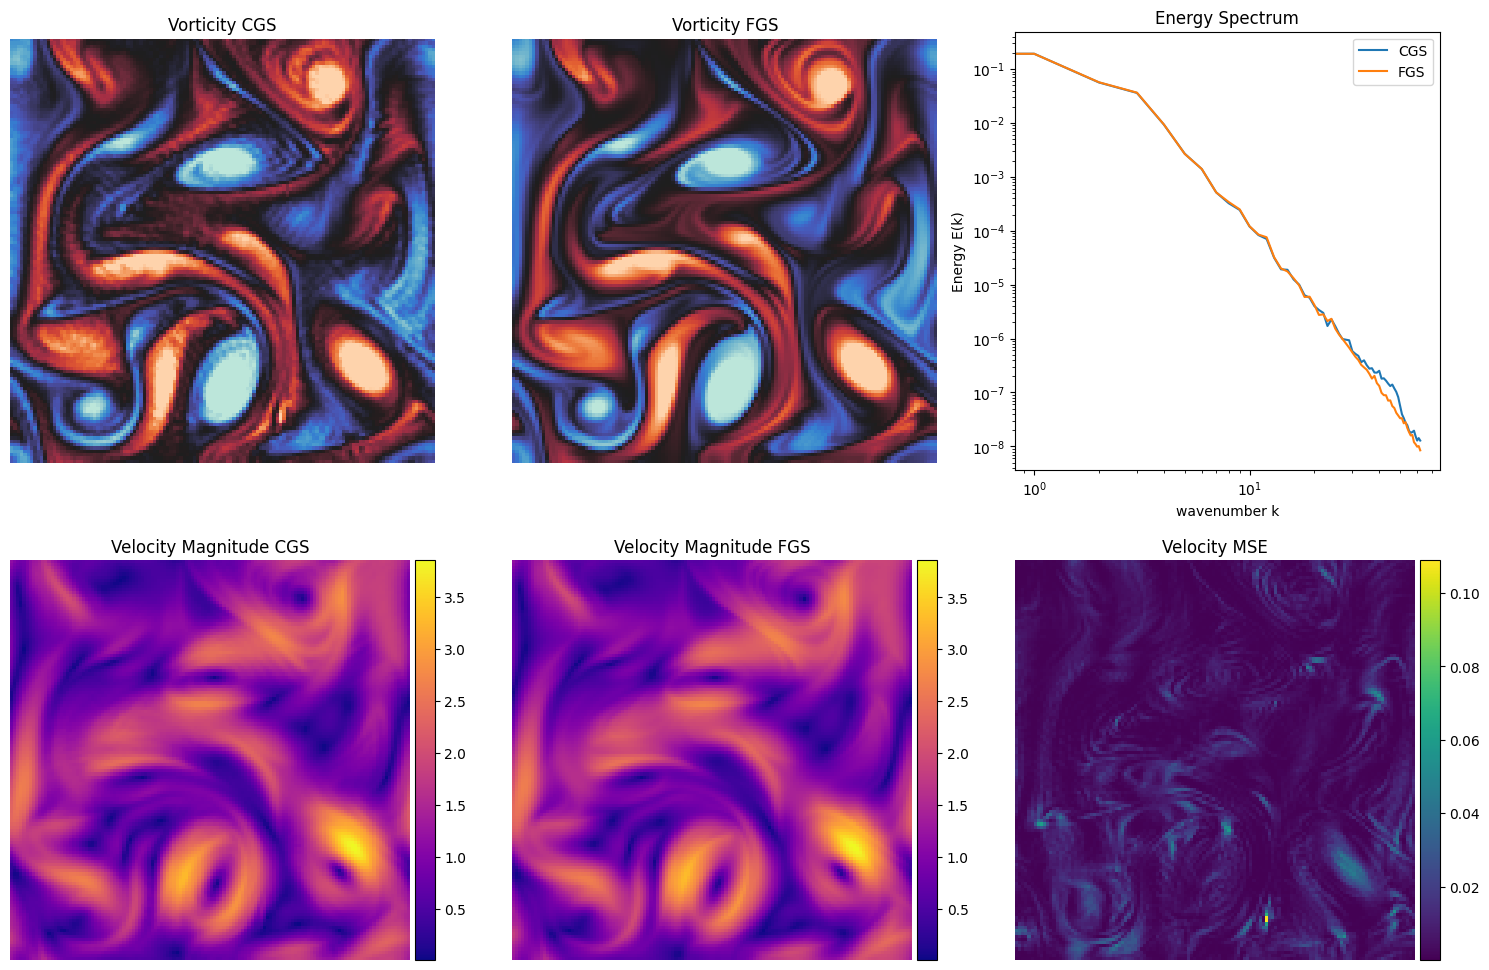

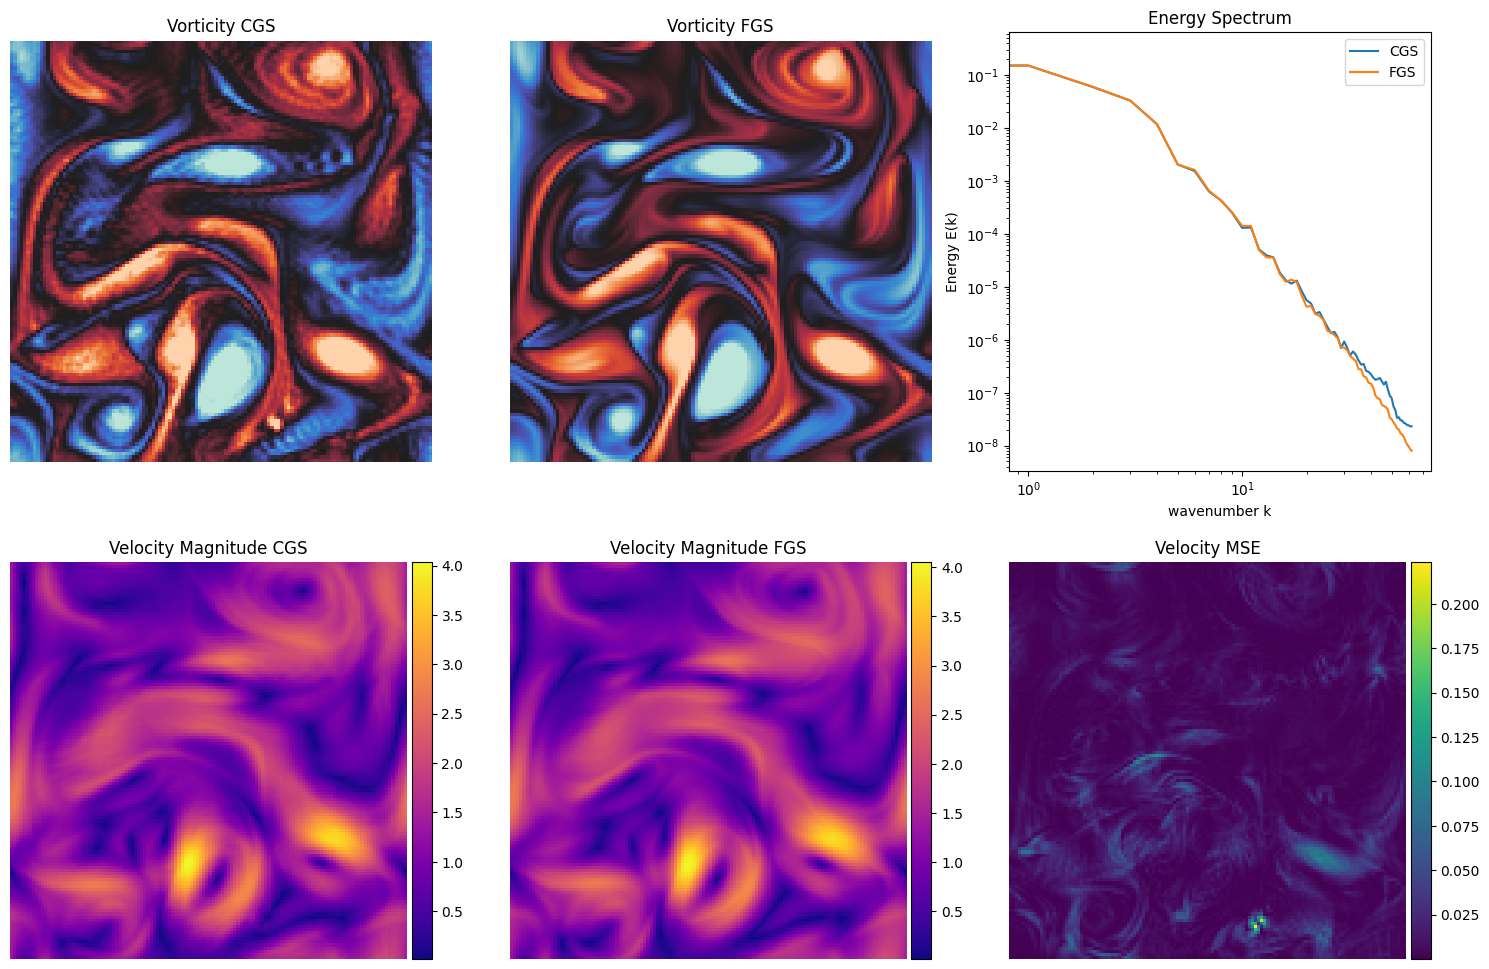

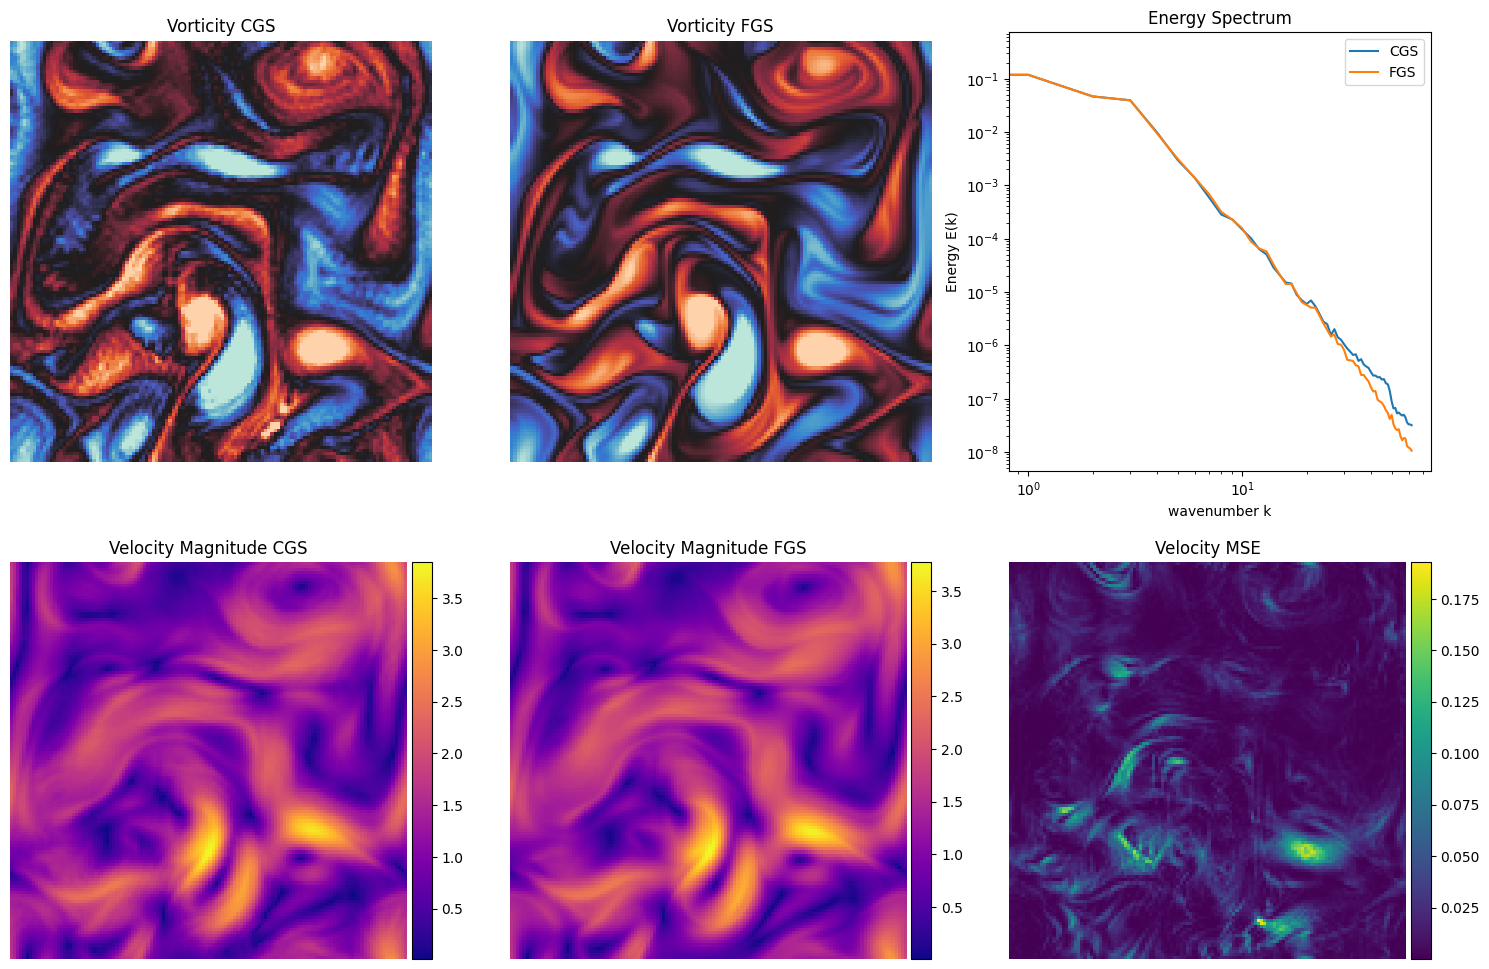

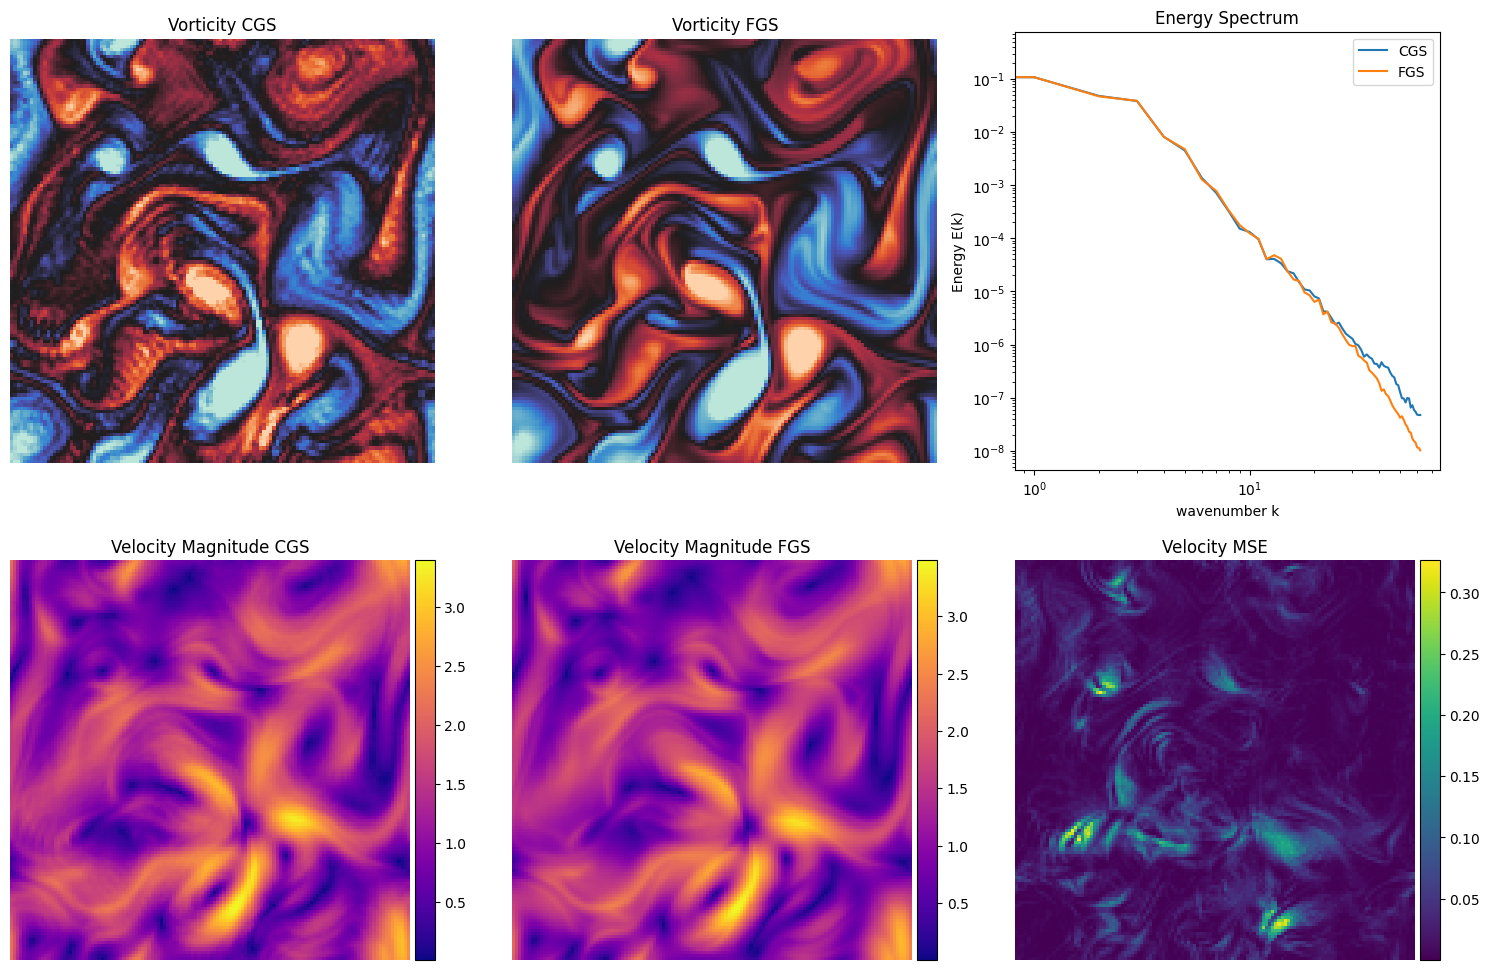

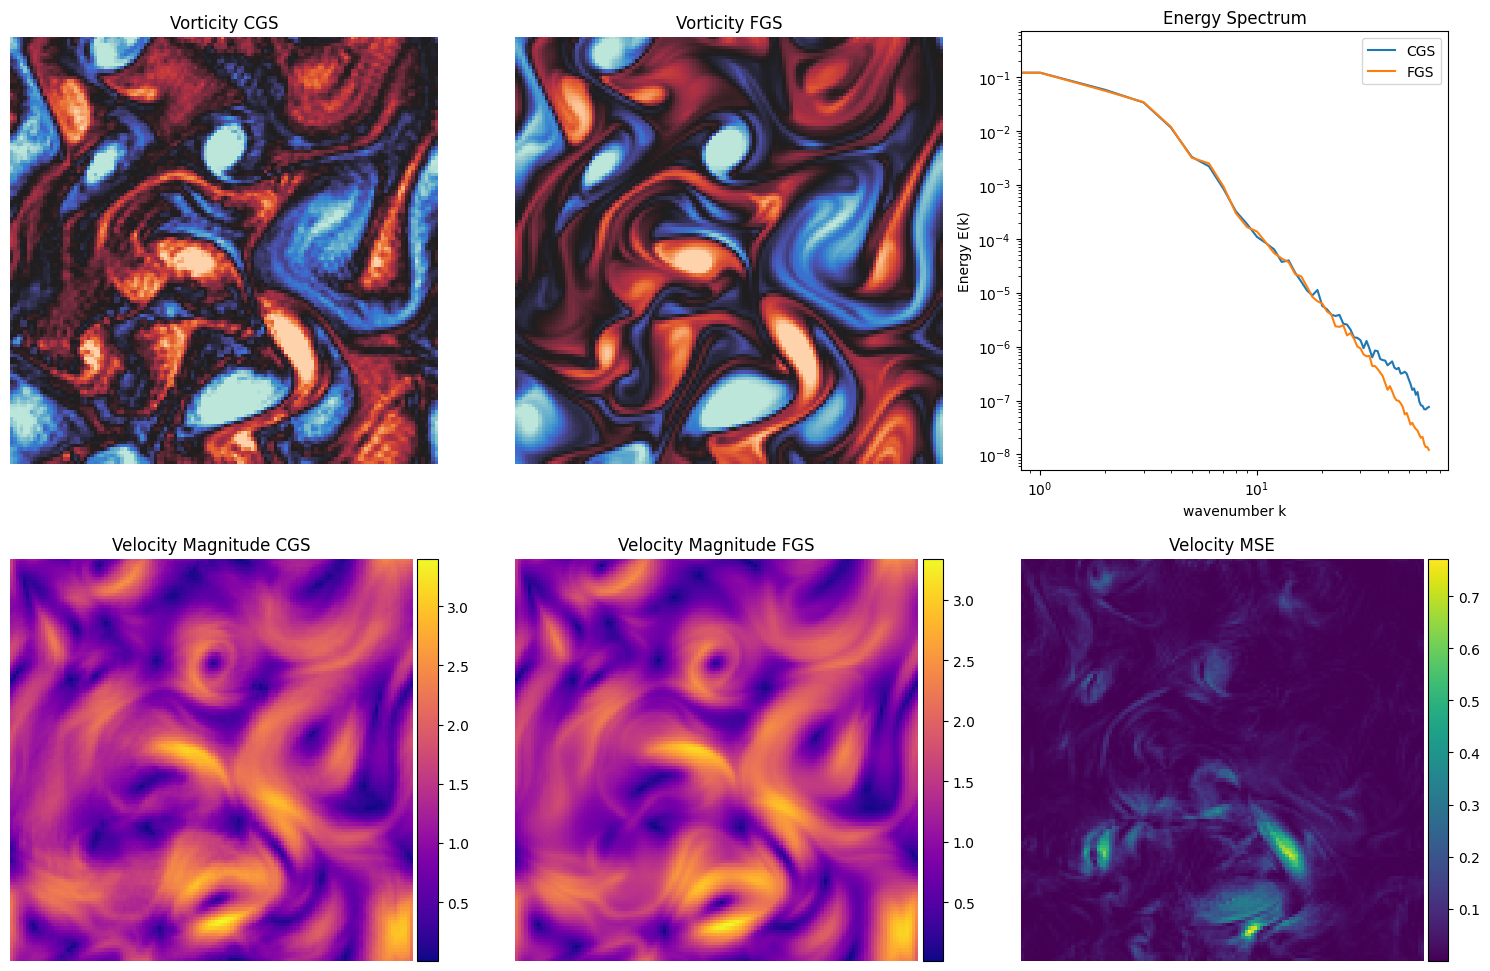

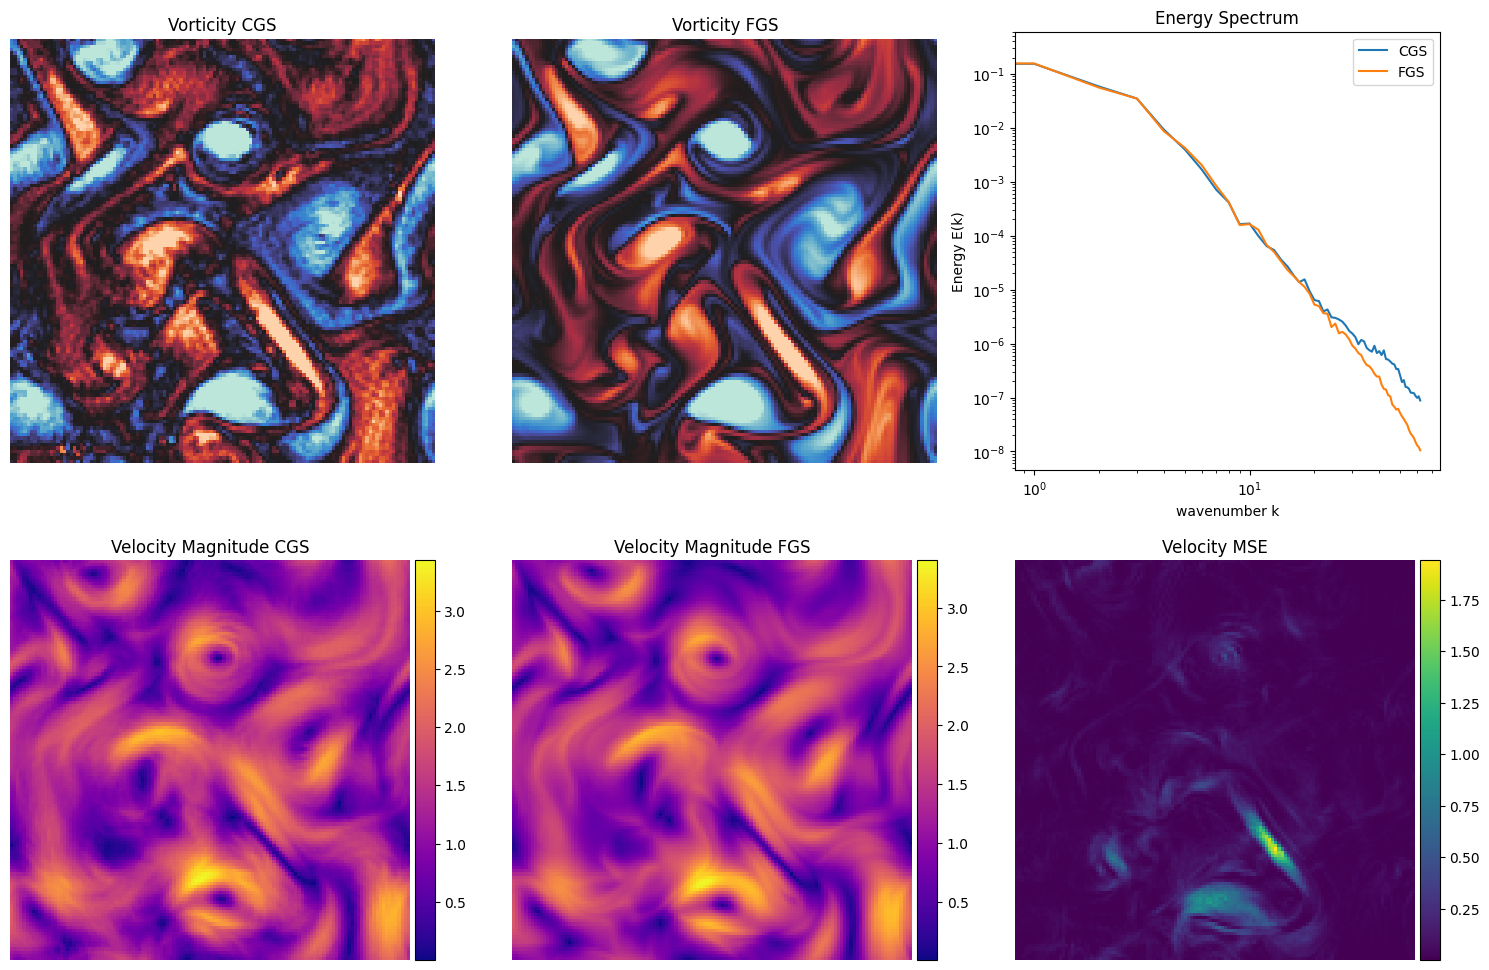

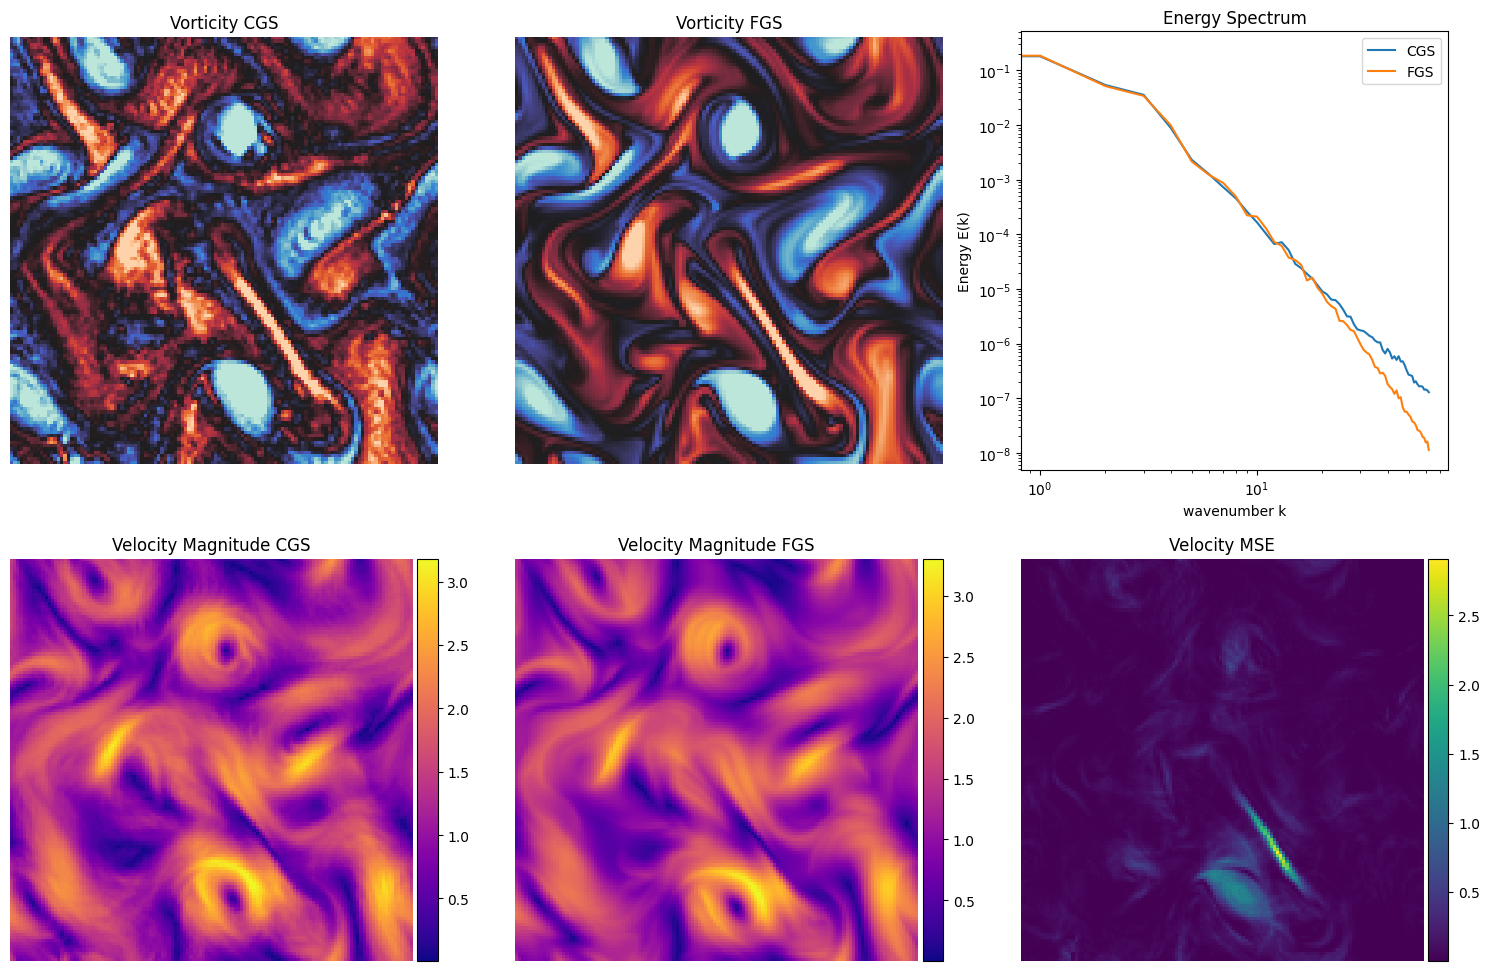

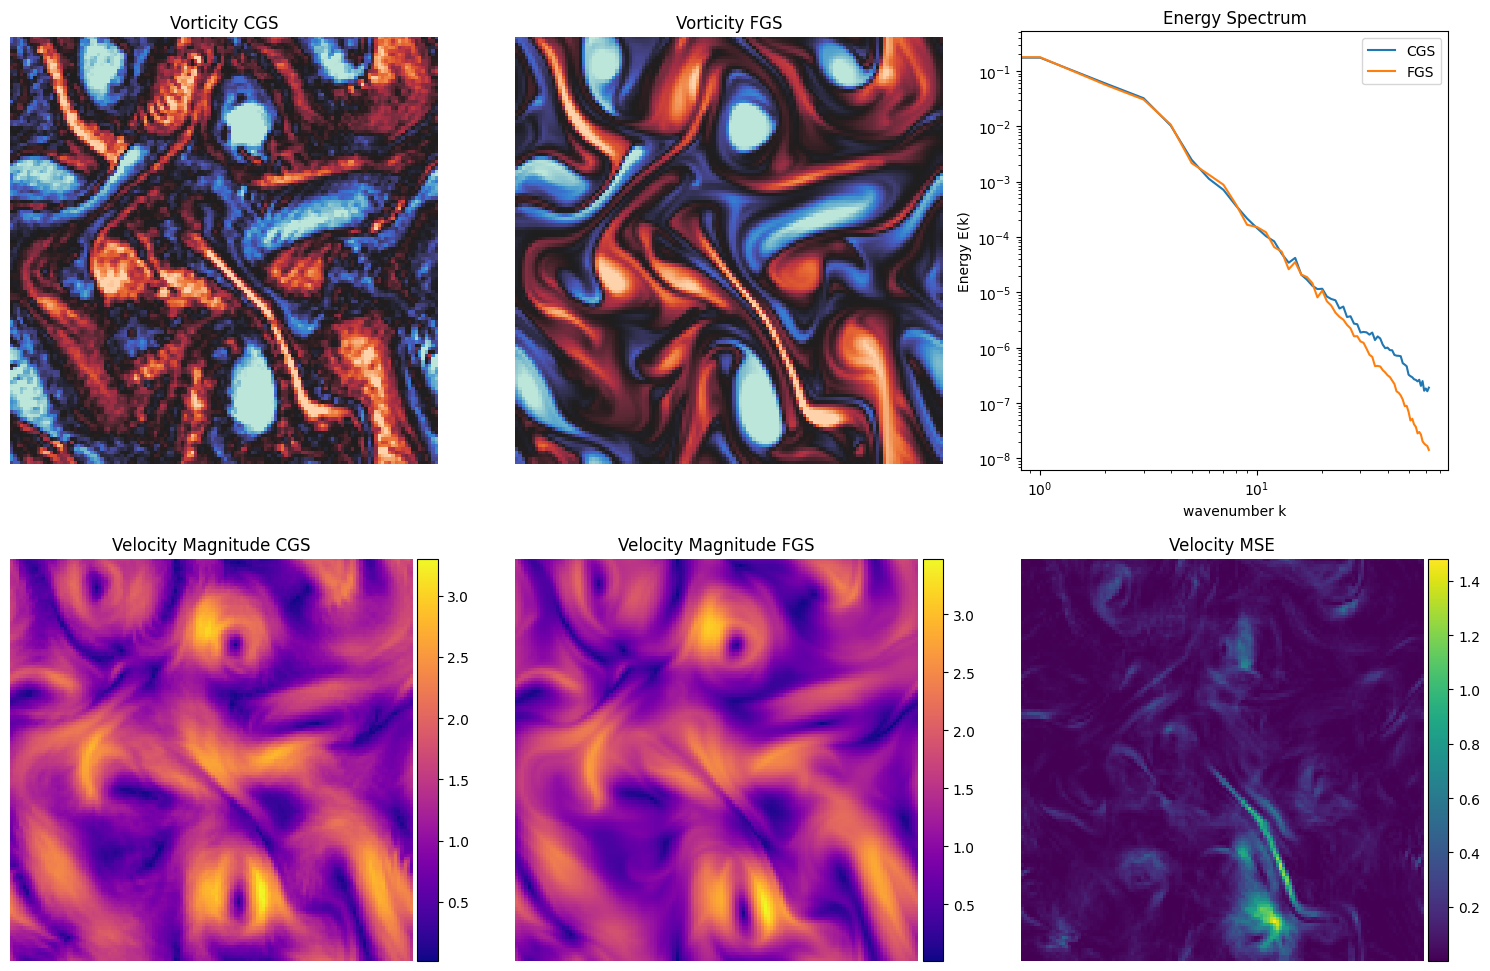

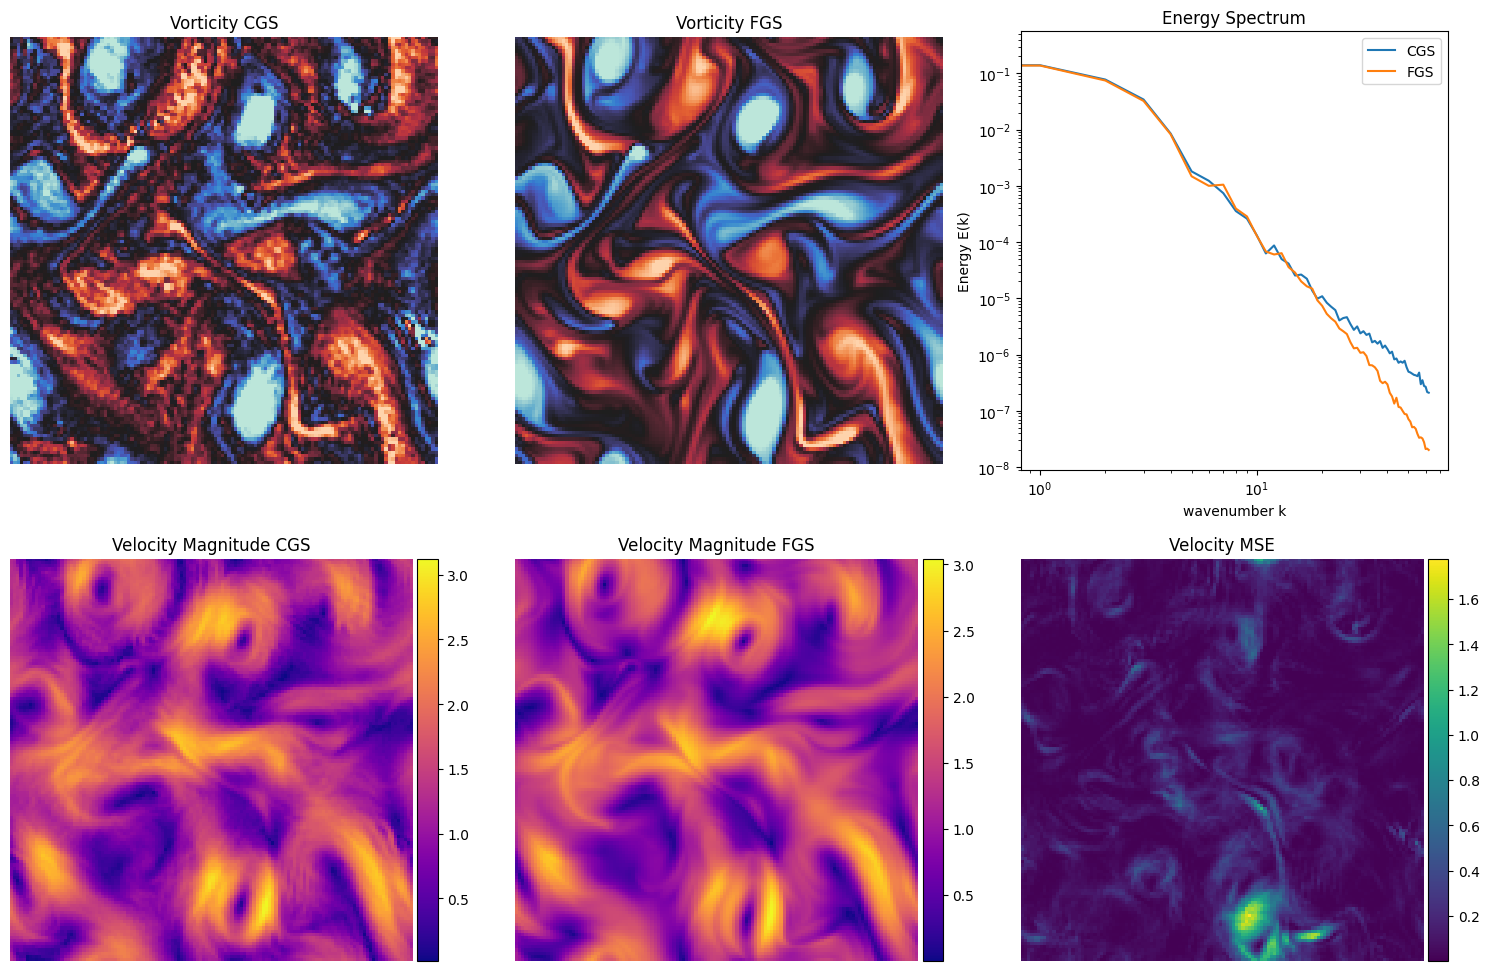

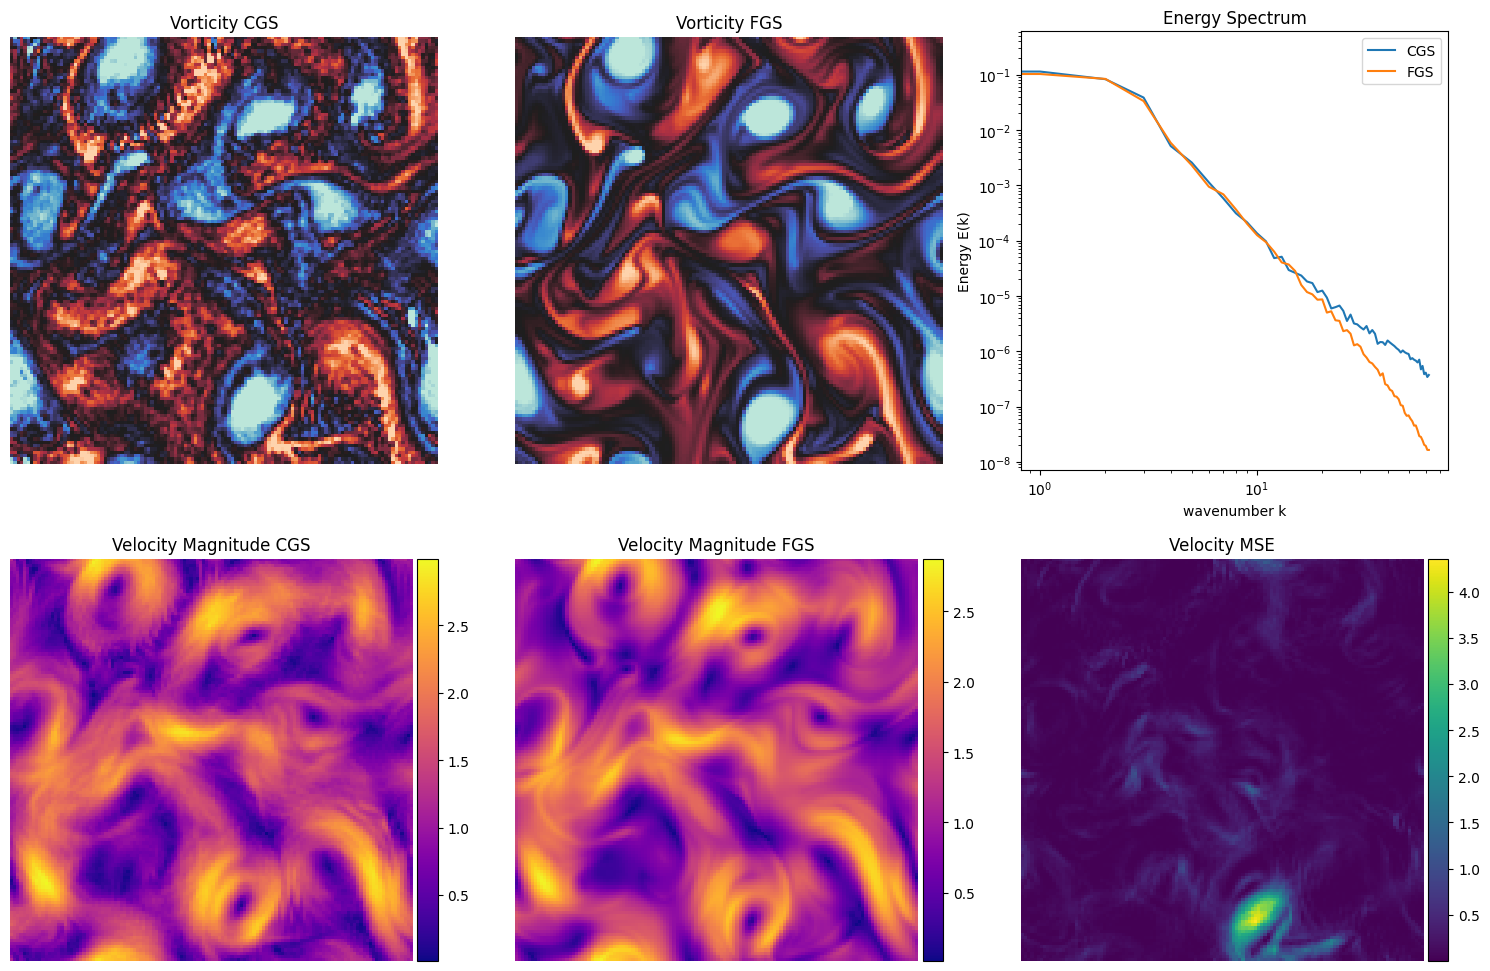

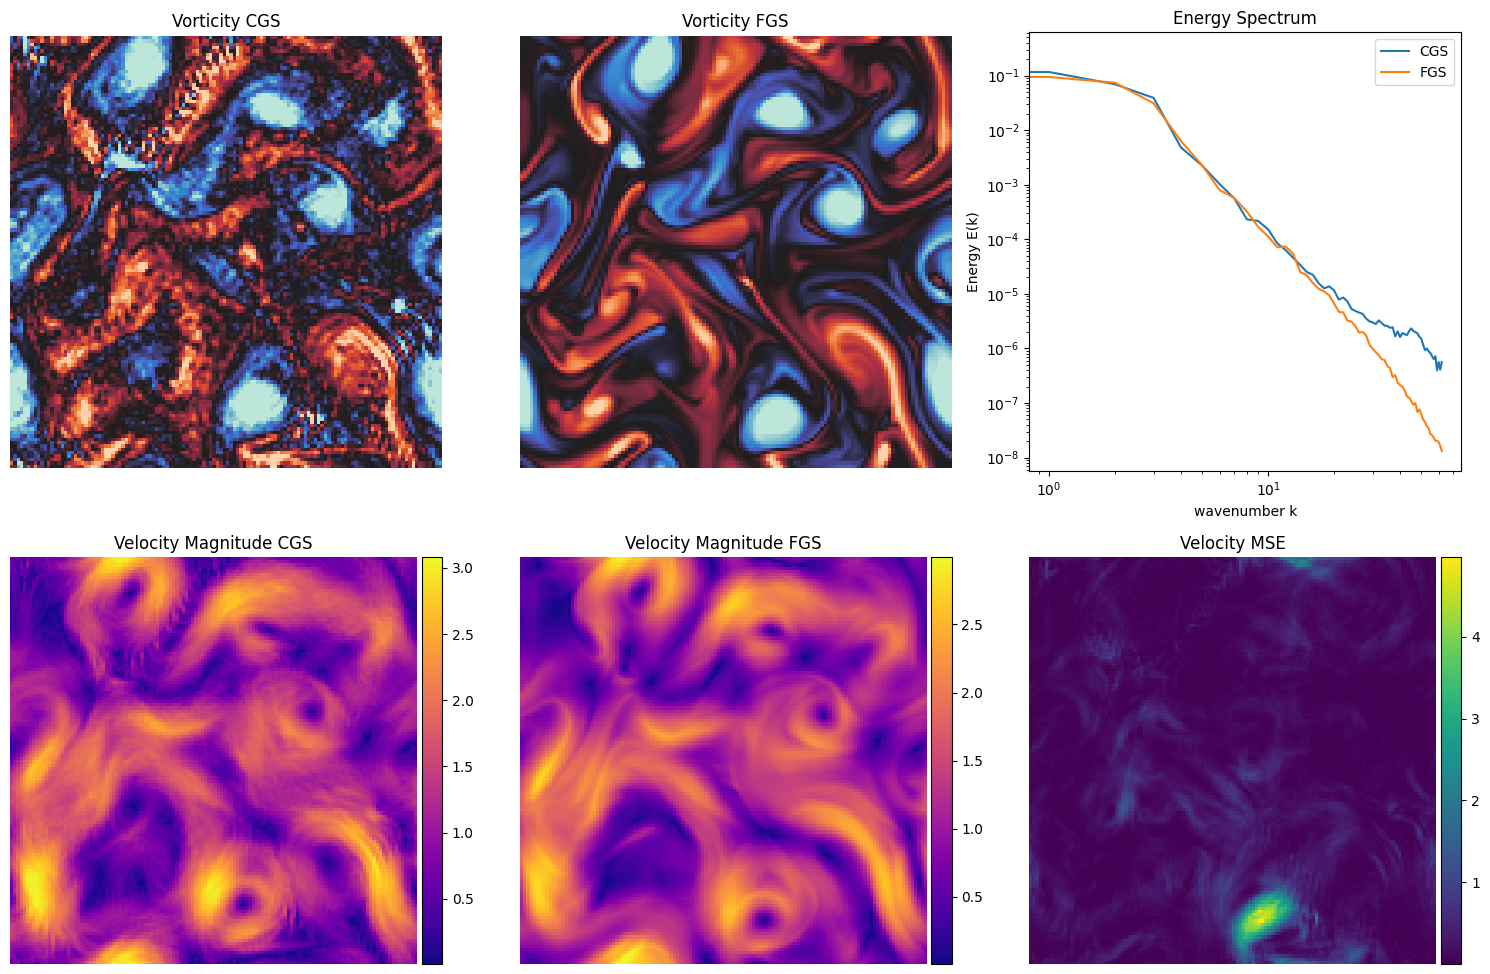

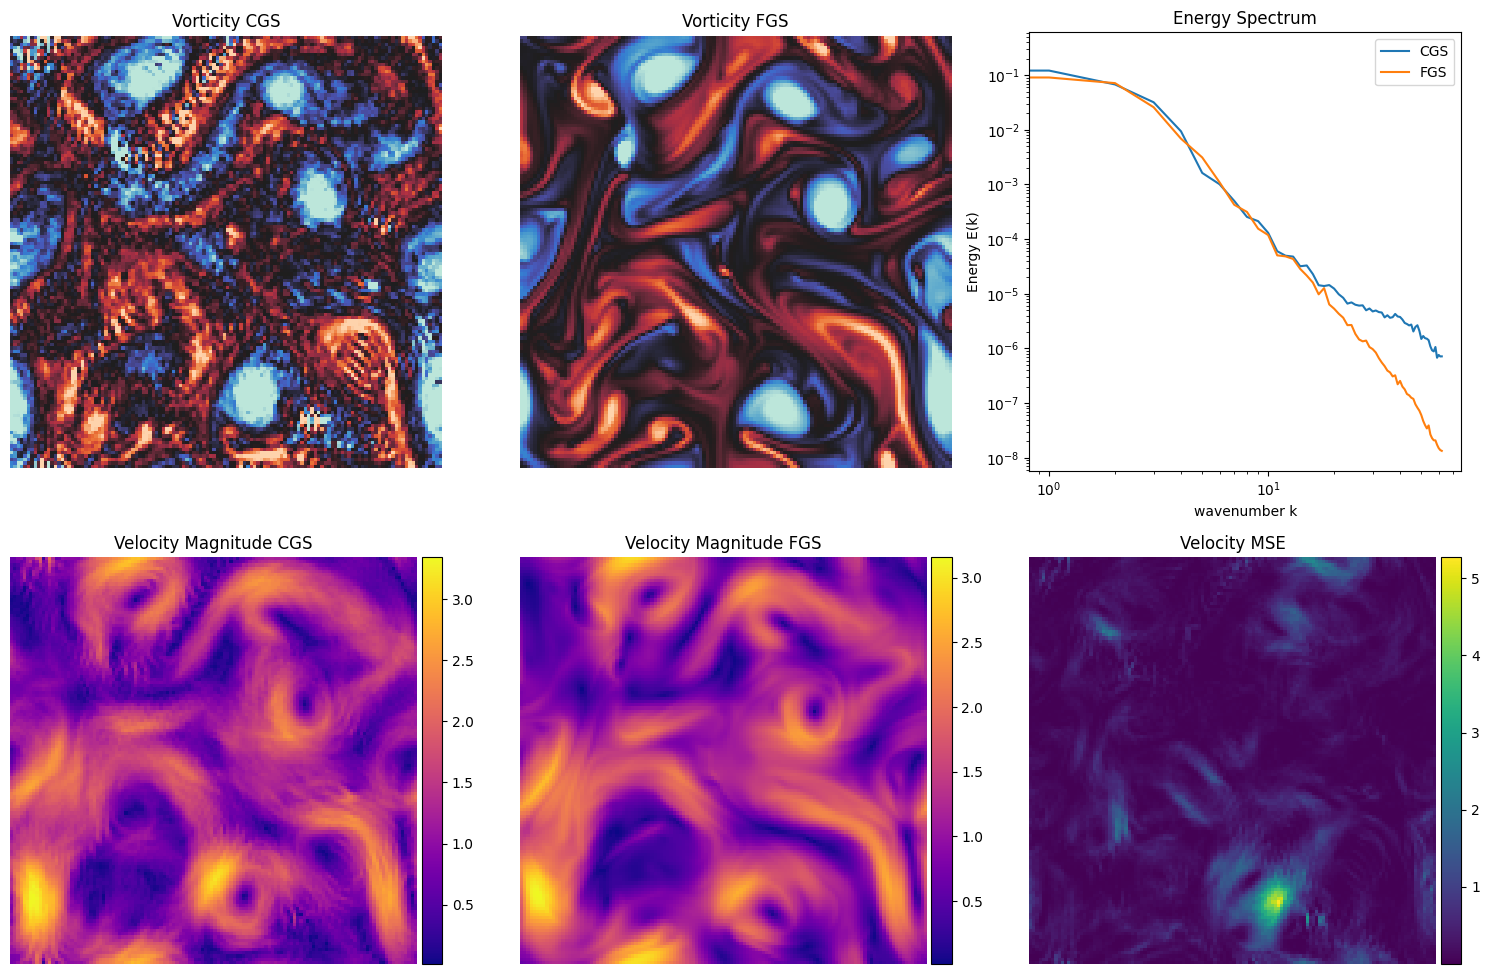

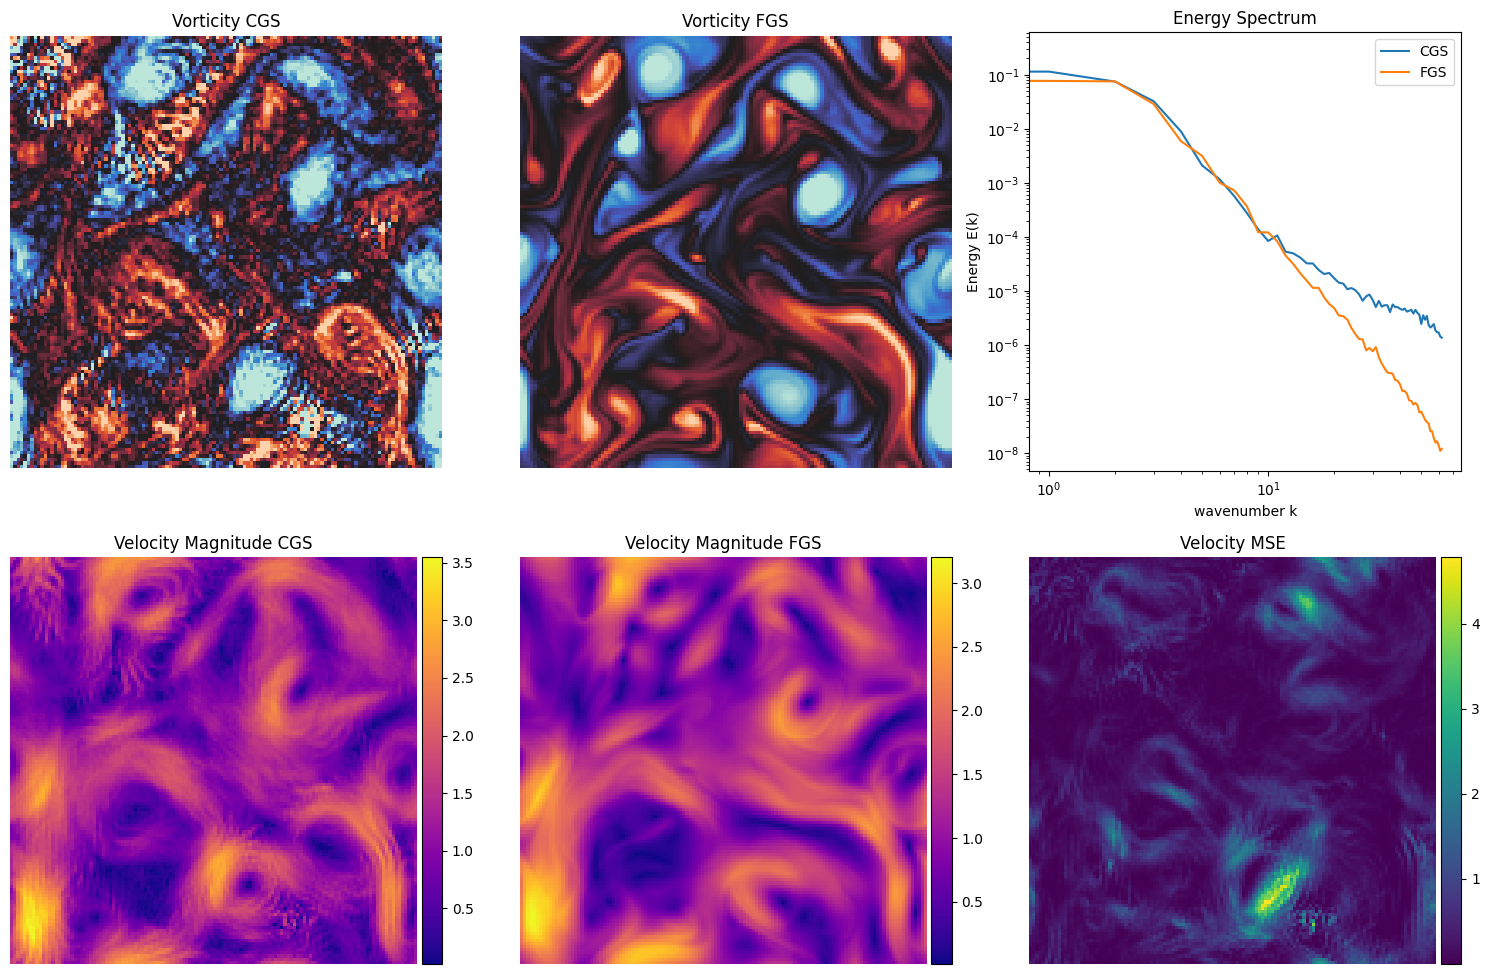

terminated
# total steps = 7887
Execution time: 39.3880295753479 seconds


In [7]:
import time
start_time = time.time()
reward = np.zeros(env.action_space.shape)
discounted_reward = 0
f_min, f_max, f_mean=0.,0.,0.
gamma = 0.97
step = 0
act = np.zeros(env.action_space.shape)
obs ,inf = env.reset()
episode_is_over = False
rews = []
obss = []
while not episode_is_over:
    if step%500==0:
        #env.render()
        plot_analysis(env, step, save_fig=False)

    obs, rew, terminated, truncated, inf = env.step(act)
    reward += rew
    discounted_reward += rew * gamma**step 
    f_min = np.min([f_min, obs.min()])
    f_max = np.max([f_min, obs.max()])
    f_mean += obs.mean()
    step += 1
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

f_mean /= step

print(f"# total steps = {step}")
env.close()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [8]:
env.close()